In [1]:
import os
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd

import numpy as np 
import librosa

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
## Following is used to load our datasets into the Dataloader
def creating_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader



In [3]:
### Training multiple models 
def train(model, data_loader, loss_fn_a,loss_fn_b, optimiser, device, our_epochs, file_name):
    ## keep track of best model     
    best_valid_acc = 0.0
    saved_model = './best_model'
    evaluate_every_epoch = 1

    TRAINING_ACCURACY = {}
    VALIDATION_ACCURACY = {}
    for epoch in range(our_epochs):
        print(f"Epoch {epoch+1}")
        
        # our_loss_a = train_one_epoch_a(model, data_loader, loss_fn_a, optimiser, device)
        # our_loss_b = train_one_epoch_b(model, data_loader, loss_fn_b, optimiser, device)
        # print(f"Loss A:{our_loss_a}, Loss B:{our_loss_b}")
        our_loss = train_one_epoch_combined(model, data_loader, loss_fn_a,loss_fn_b, optimiser, device)
        print(f"Our loss {our_loss}")
        print("---------------------------")
        
        
      
      # evaluate the network on the validation data
        if((epoch+1) % evaluate_every_epoch == 0):
            training_acc = full_evaluation(model, train_data)
            valid_acc = full_evaluation(model, valid_data)
            t_accuracy = {epoch:training_acc}
            v_accuracy = {epoch:valid_acc}
            TRAINING_ACCURACY.update(t_accuracy)
            VALIDATION_ACCURACY.update(v_accuracy)
            print('Validation accuracy: %g' % valid_acc)

            # if the best validation performance so far, save the network to file 
            if(best_valid_acc < valid_acc):
                best_valid_acc = valid_acc
                print(f'Saving best {file_name} model')
                torch.save(model.state_dict(), f'./Combined_{file_name}_model_for_gender_and_vowel_classification')
    print()
    print("---------------------------")
    print("Finished training")
    return  TRAINING_ACCURACY, VALIDATION_ACCURACY



In [4]:
## Function used to train 1 epoch 
def train_one_epoch_combined(our_model, data_loader, loss_fn_1,loss_fn_2, optimiser, device):
    print("Traininig")
    for inputs, target in data_loader:
    
        ## Ensure that our data is loaded to device
        target_a = target[0].type(torch.FloatTensor)
        target_b = target[1].type(torch.LongTensor)
        # target = target.type(torch.LongTensor)
        
        # print("target before", type(target))
        inputs = inputs.to(device)
        # target = target.to(device)
        
        target_a = target_a.to(device)
        target_b = target_b.to(device)
        # print("target after", type(target))
        
        
        # calculating model loss
        prediction_a, prediction_b = our_model(inputs)
#         print("Our prediction is:", prediction, type(prediction))
#         print("Our target value is:", target, type(target))
        
        prediction_a = prediction_a.squeeze()
        prediction_b = prediction_b.squeeze()
        # print("Modified prediction", prediction)
        loss_1 = loss_fn_1(prediction_a, target_a)
        loss_2 = loss_fn_2(prediction_b, target_b)
        loss = loss_1 +loss_2
        
        # print("Our loss is:", loss.item())

        # backpropagagation of error 
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"loss: {loss.item()}")
  

In [5]:

def single_evaluation(model, input, target):
    model.eval()
    with torch.no_grad():
        predictions_a,predictions_b = model(input)#.to('cpu')
        # print("Our prediction", predictions)
        ## If predicted over threshold, then predict as class=1 else 0 
        # print("Predictions A:", predictions_a)
        # print("Predictions B:", predictions_b)

        if predictions_a > 0.5:
            predicted_a_index = 1
        else:
            predicted_a_index = 0
        # print("Predicted output",predicted_index)
        predicted_b_index = predictions_b[0].argmax(0).item()
        # print(predicted_index.item())
        # print(target)
        target_a = target[0]
        target_b = target[1]
    return predicted_a_index, target_a, predicted_b_index, target_b 




def full_evaluation(model,dataset):
    our_predictions = []
    our_target = []
    our_predictions_a = []
    our_target_a = []
    our_predictions_b = []
    our_target_b = []
    
    for i in range(len(dataset)):
       
        inputs, targets = dataset[i][0], dataset[i][1]
        inputs = inputs.unsqueeze_(0)
        ## call our single evaluation function and use recursivity to loop through all our inputs 
        
        pred_a, act_a, pred_b, act_b =single_evaluation(model, inputs, targets)
        
        our_predictions.append((pred_a,pred_b))
        our_target.append((act_a, act_b))
        our_predictions_a.append(pred_a)
        our_predictions_b.append(pred_b)
        our_target_a.append(act_a)
        our_target_b.append(act_b)
        

    print("Finished")
    ## evaluation of our output using accuracy score
    
    test_acc_a = accuracy_score(our_predictions_a, our_target_a)
    test_acc_b = accuracy_score(our_predictions_b, our_target_b)
    # combine the test accuracy to obtain mean accuracy across the 2 tasks.
    test_acc = (test_acc_a + test_acc_b)/2


    # print(our_predictions_a)
    # print(our_predictions_b)
    return test_acc



In [6]:
class VocalDataset(Dataset):

    def __init__(self,
                 binarylabelcsv,
                 audiofilefolder,
                 transformer,
                 target_sample_rate,
                 number_of_samples,
                 device):
        self.annotations_file = pd.read_csv(binarylabelcsv)
        self.audiofilefolder = audiofilefolder
        self.device = device
        ## our data is loaded to the device in order to use GPU or CPU 
        self.transformer = transformer.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.number_of_samples = number_of_samples
    
    ## Used to check the length of our dataset 
    def __len__(self):
        return len(self.annotations_file)

    def __getitem__(self, index):
        
        audio_sample_path = self._get_file_path(index)
     
        ## We obtain the two labels which will be attached to each of our mel-spectorgram input image generated
        label_1, label_2 = self._get_label(index)
        ## load our audio
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._cut_length_if_required(signal)
        
        ## Convert the signal data into mel_spectogram
        signal = self.transformer(signal)
        
        return signal, [label_1,label_2]

 
    def _cut_length_if_required(self, signal):
        ## following ensures that our samples have the same shape
        if signal.shape[1] > self.number_of_samples:
            ## Slice the signal if its too long
            signal = signal[:, :self.number_of_samples]
        return signal


    def _get_label(self, index):
        ##  Read the specific annotations from the csv dataset 
       
        ## 5 = 'gender_label_transorm' column for label_1,  6 ='vowel_label_mapped' column for label_2  
        return self.annotations_file.iloc[index, 5], self.annotations_file.iloc[index, 6]
    

    
    def _get_file_path(self, index):
        ## Our csv dataset contains the corresponding index for our particular task
        ## and 1 is the path file 'file_name_data'
        path = os.path.join(self.audiofilefolder,self.annotations_file.iloc[
            index, 1]+".wav")
        return path



In [7]:
## Previous CNN model 
# class CnnNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels=1,
#                 out_channels=20,
#                 kernel_size=3,
#                 stride=1,
#                 padding=2
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels=20,
#                 out_channels=40,
#                 kernel_size=3,
#                 stride=1,
#                 padding=2
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels=40,
#                 out_channels=80,
#                 kernel_size=3,
#                 stride=1,
#                 padding=2
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.flatten = nn.Flatten()
#         self.linear = nn.Linear(5040, 100)
#         self.dropout = nn.Dropout(0.1)
#         self.linear2 = nn.Linear(100, 5)
#         ## softmax output layer 
#         self.output = nn.Softmax(dim=1)


#     def forward(self, input_data):
#         # print("Input_shape",input_data.shape)
#         x = self.conv1(input_data)
#         # print("Conv 1",x.shape)
#         x = self.conv2(x)
#         # print("Conv 2",x.shape)
#         x = self.conv3(x)
#         # print("Conv 3",x.shape)
#         x = self.flatten(x)
#         # print("Flatten ",x.shape)
#         x = self.linear(x)
#         # print("Linear 1 1",x.shape)
#         x = self.dropout(x)
#          # print("Dropout 1",x.shape)
        
#         x = self.linear2(x)
#         # print("Linear 2",x.shape)
        

#         ## softmax output layer
#         finalpredictions = self.output(x)
        
#         return finalpredictions




In [8]:
class Combined_CNN_Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        ## CNN network 
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=20,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels=40,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=40,out_channels=80,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
    
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(5040, 100)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(100, 1)
    
        
        self.gender = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(5040, 100),
                    nn.Dropout(0.1),
                    nn.Linear(100, 1))
                    
        self.vowel = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(5040, 100),
                    nn.Dropout(0.1),
                    nn.Linear(100, 5))
            
        self.output = nn.Softmax(dim=1)
        

    def forward(self, input_data):
        
        ## Predicting gender
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gender(x)
        x_final_prediction = torch.sigmoid(x)
        ## Predicting Vowel
             
        y = self.conv1(input_data)
        y = self.conv2(y)
        y = self.conv3(y)
        y = self.vowel(y)
        y_final_prediction = self.output(y)
        
        
        return x_final_prediction, y_final_prediction



        

In [9]:
## Previous ANNNetwork model 
# class ANNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
        

#         self.flatten = nn.Flatten()
#         self.dropout = nn.Dropout(0.1)
#         self.linear1 = nn.Linear(2816, 600)
        
#         self.linear2 = nn.Linear(600, 100)
#         self.linear3 = nn.Linear(100, 50)
#         self.linear4 = nn.Linear(50,5)
       
#         self.output = nn.Softmax(dim=1)

#     def forward(self, input_data):
#         # print("Input_shape",input_data.shape)
        
#         x = self.flatten(input_data)
#         # print("Flatten ",x.shape)
#         x = self.linear1(x)
#         x = self.dropout(x)
#         # print("Linear 1 1",x.shape)
#         x = self.linear2(x)
#         x = self.dropout(x)
#         # print("Linear 2",x.shape)
#         x = self.linear3(x)
#         x = self.dropout(x)
#         # print("Linear 3",x.shape)
#         x = self.linear4(x)
#         # print("Linear 4",x.shape)
        
#         final_prediction = self.output(x)
#         # print("Output Layer:", final_prediction.shape)
        
#         return final_prediction




In [10]:
class Combined_ANN_Network(nn.Module):
    def __init__(self):
        super().__init__()
        
    
        ## ANN
        self.ann_1 = nn.Sequential( 
                        nn.Flatten(),
                        nn.Linear(2816, 600),
                        nn.Dropout(0.2),
                        nn.Linear(600, 100),
                        nn.Dropout(0.1),
                        nn.Linear(100, 50),
                        nn.Dropout(0.1),
                        nn.Linear(50,1))
        
        self.ann_2 = nn.Sequential( 
                        nn.Flatten(),
                        nn.Linear(2816, 600),
                        nn.Dropout(0.2),
                        nn.Linear(600, 100),
                        nn.Dropout(0.1),
                        nn.Linear(100, 50),
                        nn.Dropout(0.1),
                        nn.Linear(50,5))
        
        self.output = nn.Softmax(dim=1)

    def forward(self, input_data_x):
        
   
        x = self.ann_1(input_data_x)
        x_final_prediction = torch.sigmoid(x)
        
        y = self.ann_2(input_data_x)
        y_final_prediction = self.output(y)
        
        # print("Output Layer:", final_prediction.shape)
        return x_final_prediction, y_final_prediction







In [11]:
if __name__ == "__main__":
    ## --------------- Initialising our variables.
    ## Using GPU
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using {device}")
    
    batch_size = 100
    our_epochs = 20
    learning_rate = 0.001
    sample_rate = 22050
    number_of_samples = 22050

    
    # creating desired mel spectogram 
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
        hop_length=512,
        n_mels=64)
   
    ## Path for our data 
    binarylabelcsv = os.path.expanduser('~/Deep Learning Audio /DL_Coursework/vocal_dataset.csv')
    audiofilefolder = os.path.expanduser("~/shared_storage/ECS7013P/data_by_vowel/")
    
    print("Loading Dataset")
    # device = 'cpu'
    data = VocalDataset(binarylabelcsv,
                       audiofilefolder,
                       mel_spectrogram,
                       sample_rate,
                       number_of_samples,
                       device)
    print("Example data value")
    signal, label = data[0]
    ## ---------------
    ### Initialise 
    print(f"We have  {len(data)} samples in our dataset.")
    print(signal.shape)
    print(signal)
    print(label)
    
    
    # # # # Let's look at the spectrogram of one example
    # plt.imshow(librosa.power_to_db(signal.cpu().numpy(), ref=np.max), aspect='auto', origin='lower')
    # plt.colorbar()
    # biubiu
    
    #### The following is used to split our dataset -----
   
    def creating_our_train_test_data(data,seed):
        #### The following is used to split our dataset -----
        train_all = round(len(data)*0.8)
        test_all = round(len(data)*0.2)

        train_valid_data, test_data = torch.utils.data.random_split(data, [train_all, test_all], generator=torch.Generator().manual_seed(seed))
        train_len = round(len(train_valid_data)*0.8)
        val_len = train_all - train_len

        
        train_data, valid_data = torch.utils.data.random_split(train_valid_data, [train_len, val_len], generator=torch.Generator().manual_seed(seed))

        print("train_data len:", len(train_data))
        print("valid_data len:", len(valid_data))
        print("test_data len:", len(test_data))
        #####   ----
        return train_data, valid_data, test_data
    
    
      
    train_data, valid_data, test_data = creating_our_train_test_data(data,10)
 
    #####   ----
    
    ### Training 
#   # constructing our  model and assigning to device either cpu or gpu 
    cnn = Combined_CNN_Network().to(device)
    # # visualise our network 
    print(cnn)


    ## setting loss function
    loss_fn_a = nn.BCELoss()
    loss_fn_b = nn.CrossEntropyLoss()
    ## setting optimizer 
    optimiser = torch.optim.Adam(cnn.parameters(),
                                 lr=learning_rate)
    # train model
    # train_single_epoch(cnn, train_dataloader, loss_fn, optimiser, device)
    train_dataloader = creating_data_loader(train_data, batch_size)

    
    print("Length of our train_dataloader", len(train_dataloader))
    ## Example of training 1 epoch 
    # #train_one_epoch(cnn, train_dataloader, loss_fn, optimiser, device)
    

    ## Training and save best model in desired location
    print("Starting Training our CNN network")
    cnn_train_accuracy, cnn_val_accuracy =train(cnn, train_dataloader, loss_fn_a,loss_fn_b, optimiser, device, our_epochs, 'cnn')
   
    
    print("Finished training our CNN network")
    
    ann = Combined_ANN_Network().to(device)
    # # visualise our network 
    print(ann)

    ## setting optimizer 
    optimiser = torch.optim.Adam(ann.parameters(),
                                 lr=learning_rate)
    # train model

    print("Starting Training our ANN network")
#     ## Training and save best model in desired location
    # ann_train_accuracy, ann_val_accuracy = train(ann, train_dataloader, loss_fn, optimiser, device, our_epochs, 'ann')
    ann_train_accuracy, ann_val_accuracy =train(ann, train_dataloader, loss_fn_a,loss_fn_b, optimiser, device, our_epochs, 'ann')


    print("Finished training our ANN network")






Using cuda
Loading Dataset
Example data value
We have  3442 samples in our dataset.
torch.Size([1, 64, 44])
tensor([[[1.1676e-02, 8.2902e-03, 1.6870e-02,  ..., 3.9305e-02,
          4.9815e-02, 2.6148e-01],
         [2.9888e-04, 1.6859e-03, 5.8703e-04,  ..., 9.1099e-03,
          1.0752e-02, 1.1565e+00],
         [3.6412e-06, 4.8589e-05, 6.0795e-04,  ..., 4.1969e+00,
          4.8081e+00, 7.9619e+00],
         ...,
         [2.2173e-04, 1.7561e-04, 2.0606e-04,  ..., 3.2157e-04,
          2.9273e-04, 4.9023e-04],
         [1.9601e-04, 2.4120e-04, 2.3794e-04,  ..., 3.8247e-04,
          3.8039e-04, 6.0534e-04],
         [3.5361e-04, 3.3849e-04, 2.1875e-04,  ..., 2.8031e-04,
          4.4690e-04, 3.5362e-04]]], device='cuda:0')
[1.0, 0]
train_data len: 2203
valid_data len: 551
test_data len: 688
Combined_CNN_Network(
  (conv1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [12]:
print("output")

output


In [ ]:
test_input, test_target = data[-1]

In [17]:
## Example input data 
test_input

tensor([[[1.5476e-02, 2.7525e-03, 6.3656e-03,  ..., 4.6116e-03,
          1.3773e-03, 4.5015e-03],
         [9.5848e-04, 1.0238e-03, 6.0418e-04,  ..., 1.7076e-03,
          4.1496e-04, 2.9541e-03],
         [1.8129e-04, 1.7931e-04, 5.3772e-05,  ..., 8.7678e-05,
          2.0050e-04, 4.1181e-04],
         ...,
         [1.7889e-04, 2.5393e-04, 2.2588e-04,  ..., 3.3941e-04,
          3.8310e-04, 1.8615e-04],
         [2.7728e-04, 4.0096e-04, 2.4030e-04,  ..., 3.3224e-04,
          4.0932e-04, 3.5397e-04],
         [3.9620e-04, 3.0312e-04, 4.2719e-04,  ..., 2.9490e-04,
          4.0128e-04, 3.5254e-04]]], device='cuda:0')

In [18]:
## Target data - (gender class, vowel class)
test_target

[1.0, 4]

In [19]:
## Output result - (predicted_gender_class, actual_gender_class, predicted_vowel_class, actual_vowel_class)
single_evaluation(cnn, test_input.unsqueeze_(0), test_target)

(1, 1.0, 2, 4)

In [33]:
## Function to plot the accuracy during epochs 
def plot_model_accuracy(train_accuracy, valid_accuracy):
    t_epochs = list(train_accuracy.keys())
    t_acc= list(train_accuracy.values())
    v_acc = list(valid_accuracy.values())
    plt.title('Combined Network \n Training and Validation accuracy')
    plt.plot(t_epochs, t_acc, label ='training')
    plt.plot(t_epochs, v_acc,label='validation' )
    plt.legend(loc="upper right")
    plt.show()
    

Plot Training/Valid accuracy for Combined_ANN_Network


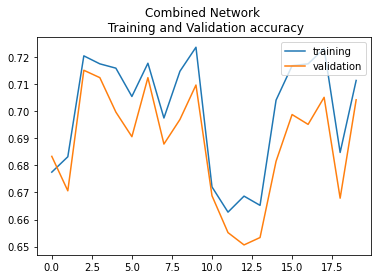

In [34]:
print("Plot Training/Valid accuracy for Combined_ANN_Network")
plot_model_accuracy(ann_train_accuracy, ann_val_accuracy)

Plot Training/Valid accuracy for Combined_CNN_Network 


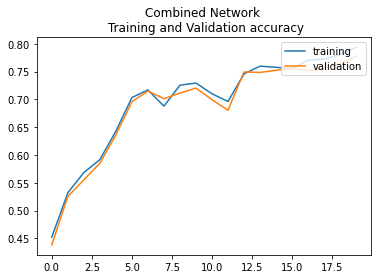

In [35]:
print("Plot Training/Valid accuracy for Combined_CNN_Network ")
plot_model_accuracy(cnn_train_accuracy, cnn_val_accuracy)

In [23]:
# m = signal.unsqueeze_(0)
our_sample_signal = signal.squeeze(0).T.cpu().numpy()


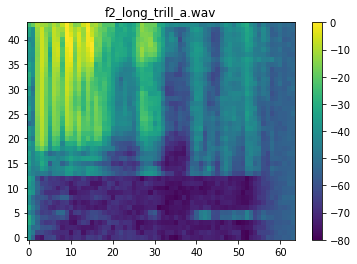

In [24]:
# # # MEl- spectogram sample example of 1
plt.title("f2_long_trill_a.wav")
plt.imshow(librosa.power_to_db(our_sample_signal, ref=np.max), aspect='auto', origin='lower')
plt.colorbar()
plt.show()


In [25]:
## Seperate function used to evaluate our test dataset and 
##  also to obtain a classification report and plot of Confusion Matrix 
def evaluating_test_dataset(model,dataset, class_mapping_a,class_mapping_b):
    our_predictions_a = []
    our_target_a = []
    our_predictions_b = []
    our_target_b = []
    class_mapping_a = class_mapping_a
    class_mapping_b = class_mapping_b
    
    
    for i in range(len(dataset)):
       
        inputs, targets = dataset[i][0], dataset[i][1]
        inputs = inputs.unsqueeze_(0)
        pred_a, act_a, pred_b, act_b = single_evaluation(model, inputs, targets)
        our_predictions_a.append(pred_a)
        our_target_a.append(act_a)
        our_predictions_b.append(pred_b)
        our_target_b.append(act_b)

    print("Finished")
    test_acc_a = accuracy_score(our_predictions_a, our_target_a)
    print("Results for predicting Gender Classfication")
    print()
    report =classification_report(our_target_a, our_predictions_a, target_names=class_mapping_a)
    print('Accuracy is: %g' % test_acc_a)
    print('Classification Report : \n' , report)
    cm = confusion_matrix(our_target_a, our_predictions_a )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_mapping_a)
    disp.plot()
    
    print("Results for predicting Vowel Classification")
    print()
    test_acc_b = accuracy_score(our_predictions_b, our_target_b)
    report =classification_report(our_target_b, our_predictions_b, target_names=class_mapping_b)
    print('Accuracy is: %g' % test_acc_b)
    print('Classification Report : \n' , report)
    cm = confusion_matrix(our_target_b, our_predictions_b)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_mapping_b)
    disp.plot()

    plt.show()
    
    return 




Evaluation of Test data using Combined_CNN_Network 

Finished
Results for predicting Gender Classfication

Accuracy is: 0.899709
Classification Report : 
               precision    recall  f1-score   support

        male       0.94      0.88      0.91       381
      female       0.86      0.93      0.89       307

    accuracy                           0.90       688
   macro avg       0.90      0.90      0.90       688
weighted avg       0.90      0.90      0.90       688

Results for predicting Vowel Classification

Accuracy is: 0.585756
Classification Report : 
               precision    recall  f1-score   support

           a       0.75      0.65      0.69       122
           e       0.80      0.49      0.61       136
           i       0.43      0.76      0.55       139
           o       0.68      0.52      0.59       149
           u       0.54      0.53      0.53       142

    accuracy                           0.59       688
   macro avg       0.64      0.59      0.59  

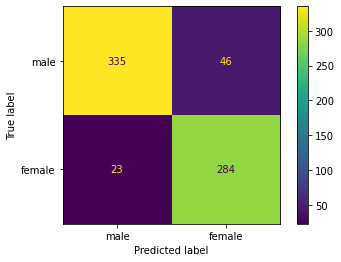

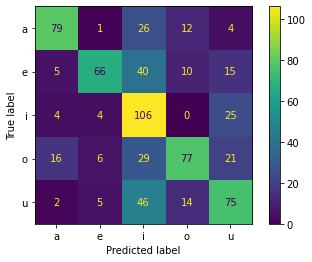

In [36]:
# ## evaluating our CNN model
network = Combined_CNN_Network().to(device)
file_name = 'cnn'
state_dict = torch.load(f"Combined_{file_name}_model_for_gender_and_vowel_classification")

network.load_state_dict(state_dict)
gender_class_mapping = [ "male","female" ]
vowel_class_mapping = ['a', 'e', 'i', 'o', 'u'] 

print("Evaluation of Test data using Combined_CNN_Network ") 

print()
## Takes both class mappings as input 
evaluating_test_dataset(network,test_data, gender_class_mapping, vowel_class_mapping)

## Can be used to obtain single evaluation 
## test_input, test_output = test_data[0]
## print(test_input.shape)
##single_evaluation(network, test_input.unsqueeze_(0), test_output)



Evaluation of Validation data using Combined_CNN_Network 
Finished
Results for predicting Gender Classfication

Accuracy is: 0.896552
Classification Report : 
               precision    recall  f1-score   support

        male       0.92      0.89      0.90       297
      female       0.87      0.91      0.89       254

    accuracy                           0.90       551
   macro avg       0.90      0.90      0.90       551
weighted avg       0.90      0.90      0.90       551

Results for predicting Vowel Classification

Accuracy is: 0.658802
Classification Report : 
               precision    recall  f1-score   support

           a       0.83      0.63      0.72       112
           e       0.91      0.60      0.72       112
           i       0.51      0.82      0.63       123
           o       0.72      0.61      0.66       100
           u       0.58      0.61      0.59       104

    accuracy                           0.66       551
   macro avg       0.71      0.65      0

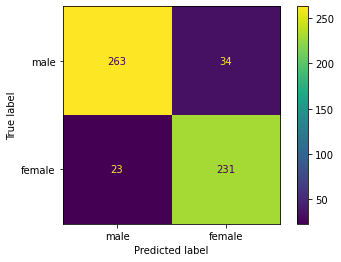

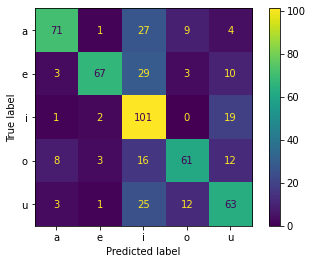

In [37]:
print("Evaluation of Validation data using Combined_CNN_Network ") 
evaluating_test_dataset(network,valid_data, gender_class_mapping, vowel_class_mapping)



Evaluation of Test data using Combined_ANN_Network 
Finished
Results for predicting Gender Classfication

Accuracy is: 0.856105
Classification Report : 
               precision    recall  f1-score   support

        male       0.92      0.81      0.86       381
      female       0.80      0.91      0.85       307

    accuracy                           0.86       688
   macro avg       0.86      0.86      0.86       688
weighted avg       0.86      0.86      0.86       688

Results for predicting Vowel Classification

Accuracy is: 0.514535
Classification Report : 
               precision    recall  f1-score   support

           a       0.37      0.83      0.51       122
           e       0.78      0.40      0.53       136
           i       0.70      0.42      0.53       139
           o       0.73      0.37      0.49       149
           u       0.45      0.60      0.52       142

    accuracy                           0.51       688
   macro avg       0.61      0.52      0.51   

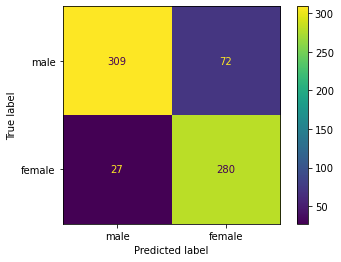

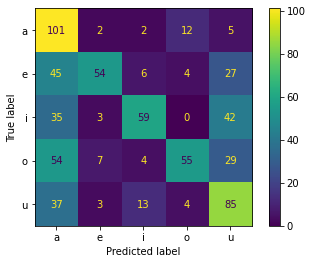

In [38]:
# ## evaluating our ANN model
network_2 = Combined_ANN_Network().to(device)
file_name = 'ann'
state_dict = torch.load(f"Combined_{file_name}_model_for_gender_and_vowel_classification")

network_2.load_state_dict(state_dict)

print("Evaluation of Test data using Combined_ANN_Network ") 



gender_class_mapping = [ "male","female" ]
vocal_class_mapping = ['a', 'e', 'i', 'o', 'u']
## Takes both class mappings as input 
evaluating_test_dataset(network_2,test_data, gender_class_mapping, vowel_class_mapping)




## test_input, test_output = test_data[0]
## print(test_input.shape)
##single_evaluation(network_2, test_input.unsqueeze_(0), test_output)



Evaluation of Validation data using Combined_ANN_Network 
Finished
Results for predicting Gender Classfication

Accuracy is: 0.874773
Classification Report : 
               precision    recall  f1-score   support

        male       0.92      0.84      0.88       297
      female       0.83      0.91      0.87       254

    accuracy                           0.87       551
   macro avg       0.88      0.88      0.87       551
weighted avg       0.88      0.87      0.87       551

Results for predicting Vowel Classification

Accuracy is: 0.555354
Classification Report : 
               precision    recall  f1-score   support

           a       0.46      0.87      0.60       112
           e       0.83      0.45      0.58       112
           i       0.74      0.44      0.55       123
           o       0.68      0.43      0.53       100
           u       0.43      0.60      0.50       104

    accuracy                           0.56       551
   macro avg       0.63      0.56      0

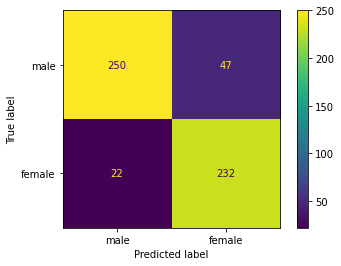

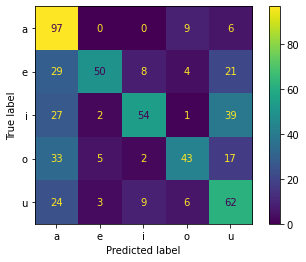

In [39]:
print("Evaluation of Validation data using Combined_ANN_Network ") 

evaluating_test_dataset(network_2,valid_data, gender_class_mapping, vowel_class_mapping)
